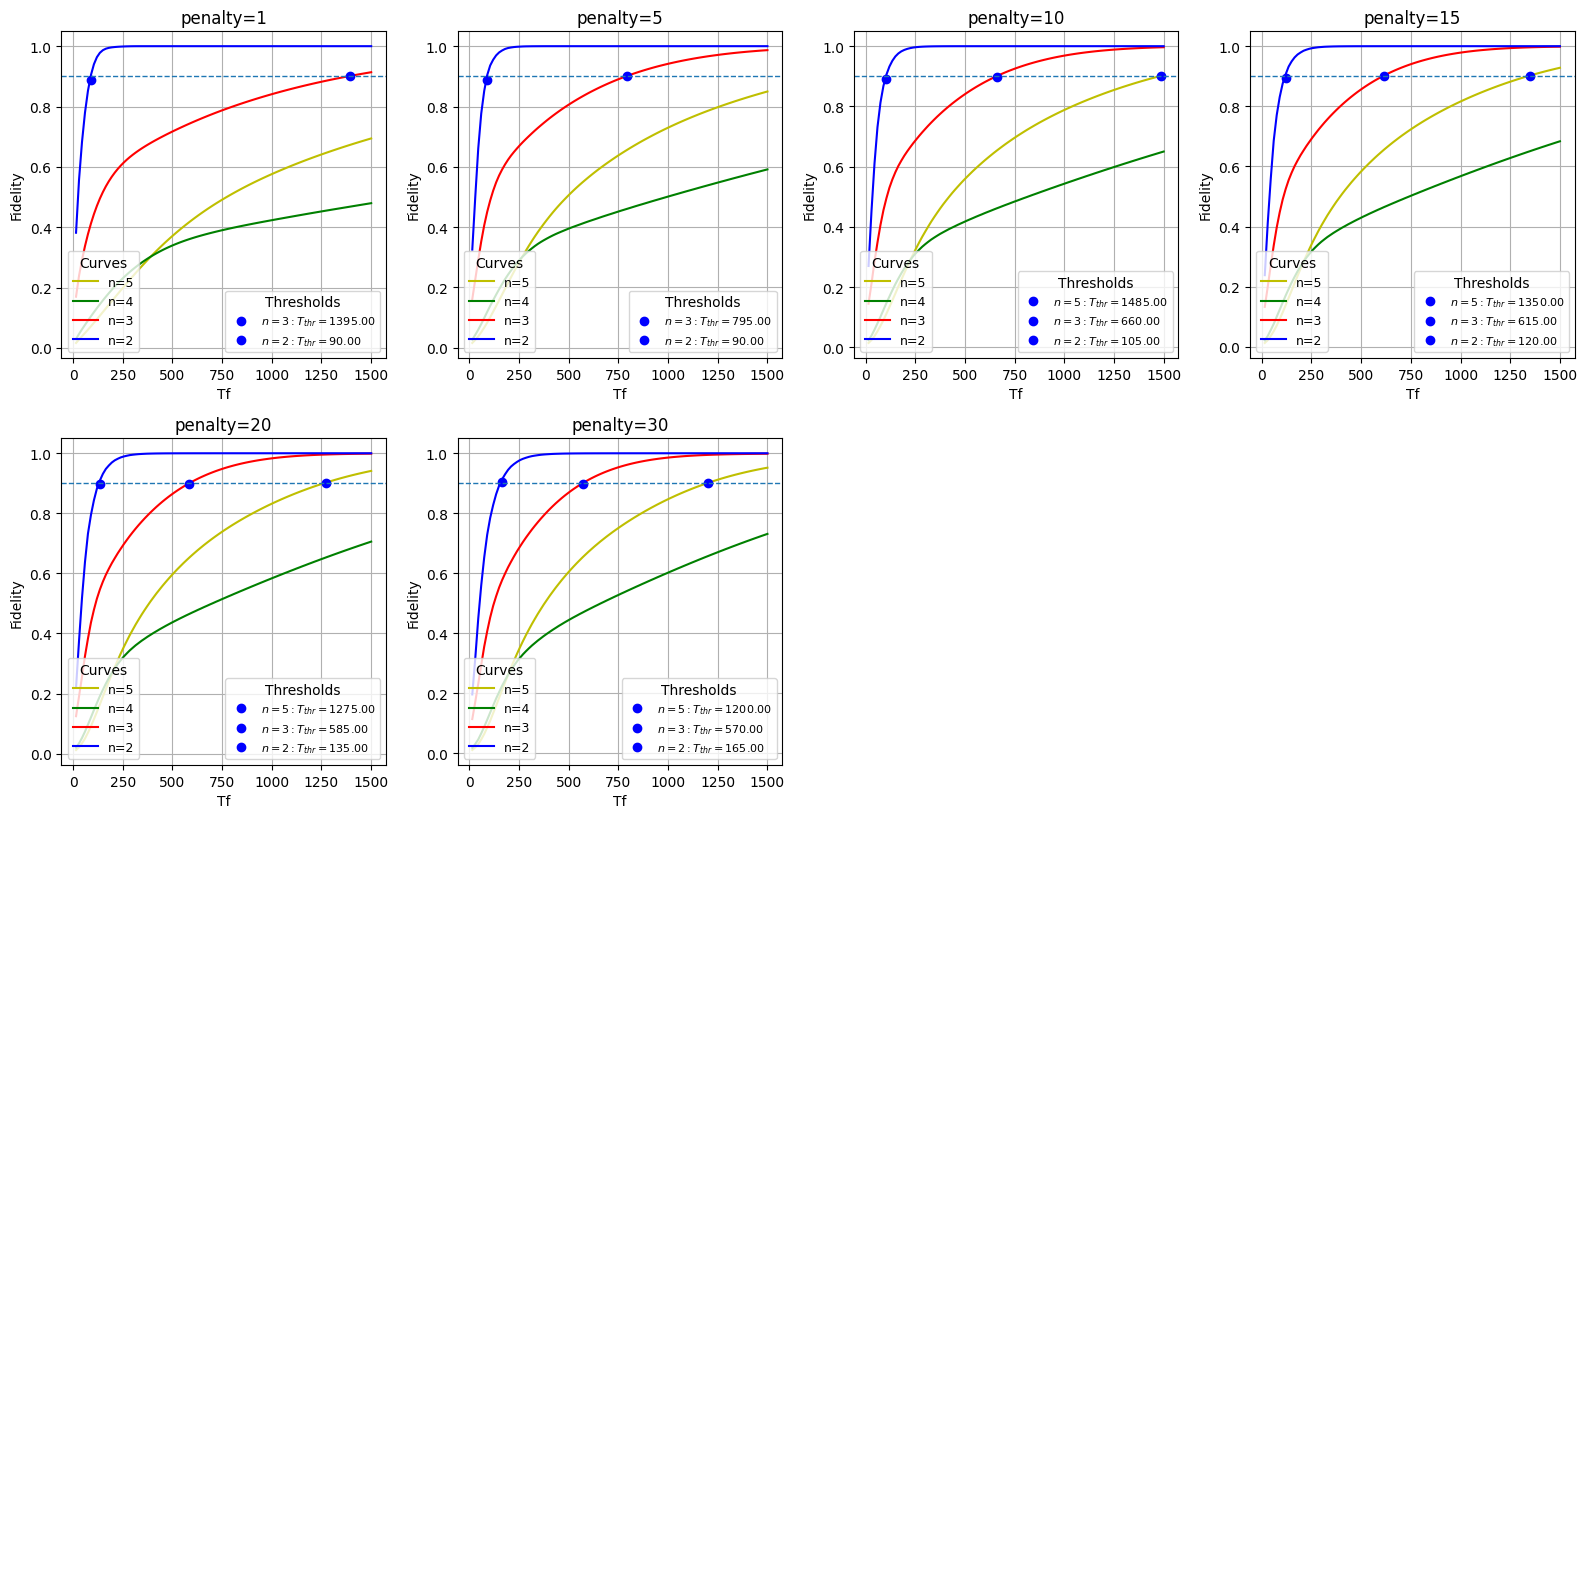

In [9]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from dataclasses import dataclass
import pandas as pd
import numpy as np
import ast
import pathlib

p = pathlib.Path("data")

threshold = 0.9

@dataclass
class FidelityData:
    steps: int
    beta: int
    T_0: int
    T_f: int
    penalty: int
    data: dict  # number -> numpy array

data_dict = {}

for file_path in p.glob("**/*.csv"):
    file_name = file_path.name

    # Parse metadata from filename
    parts = file_name.replace(".csv", "").split("_")
    meta = FidelityData(
        steps=int(parts[0]),
        beta=int(parts[1]),
        T_0=int(parts[2]),
        T_f=int(parts[3]),
        penalty=int(parts[4]),
        data={}
    )

    # Read CSV properly
    df = pd.read_csv(file_path, header=None, names=["key", "array"])

    for _, row in df.iterrows():
        meta.data[int(row["key"])] = np.asarray(
            ast.literal_eval(row["array"])
        )

    data_dict[int(meta.penalty)] = meta

data_dict = dict(sorted(data_dict.items()))

# Collect all unique n values across all files for consistent coloring
all_n = set()
for meta in data_dict.values():
    all_n.update(meta.data.keys())
all_n = sorted(all_n)

cmap = plt.get_cmap("tab10")  # up to 10 colors; use tab20 if needed
n_to_color = {n: cmap(i % cmap.N) for i, n in enumerate(all_n)}

# Prepare the grid
files = list(data_dict.keys())
n_plots = len(files)
nrows, ncols = 4, 4

fig, axes = plt.subplots(nrows, ncols, figsize=(16, 16))
axes = axes.flatten()  # flatten for easy iteration

colors = {
    2: 'b',
    3: 'r',
    4: 'g',
    5: 'y',
}

for ax, file_name in zip(axes, files):
    meta = data_dict[file_name]
    T_0, T_f, nsteps = meta.T_0, meta.T_f, meta.steps
    ts = np.linspace(T_0, T_f, nsteps)

    threshold_handles = []  # store handles for legend 2

    for key, arr in meta.data.items():
        if len(arr) != len(ts):
            raise ValueError(
                f"Length mismatch in {file_name}: ts={len(ts)}, array={len(arr)}"
            )

        # plot main curves
        ax.plot(ts, arr, label=f"n={key}", color=colors.get(key))

        if np.argmax(arr>=threshold) > 0:
            px = np.argmax(arr>=threshold)
            dx = arr[px+1] - arr[px]
            t = ts[px]
            ax.plot(ts[px]- dx/2, arr[px] - dx/2, "bo")
            # create a handle for legend with value
            handle = Line2D([], [], marker='o', linestyle='None', color='blue',
                            label=rf"$n={key}: T_{{thr}}={ts[px]:.2f}$")
            threshold_handles.append(handle)

    ax.set_title(f"penalty={meta.penalty}")
    ax.axhline(0.9, linestyle="--", linewidth=1)
    ax.set_xlabel("Tf")
    ax.set_ylabel("Fidelity")
    ax.grid(True)

    # Legend 1: curves
    leg1 = ax.legend(title="Curves", loc="lower left", fontsize=9)

    # Legend 2: threshold points
    if threshold_handles:  # only if there are thresholds
        leg2 = ax.legend(handles=threshold_handles, title="Thresholds", 
                         loc="lower right", fontsize=8)
        ax.add_artist(leg1)  # keep first legend

# Hide unused subplots
for ax in axes[len(files):]:
    ax.axis("off")

plt.tight_layout()
plt.savefig("all_plots_4x4.pdf")
plt.show()
